**Use GPT runtime:** `Runtime` -> `Change runtime time` -> `Python3` + `T4 GPU` -> `Save` -> check right-upper corner to see the connection

# NLP Example - IMDB Sentiment Classification

In this notebook, we will go through the task of sentiment analysis on [IMDB movie reviews](https://huggingface.co/datasets/imdb), utilizing various sequential models such as RNN, one-directional LSTM, and a transformer architecture, specifically DistilBERT. We will explore the following key steps:

1. Tokenization
2. Building a Sequential Model
3. Model Training and Validation
4. Saving and Loading Model Checkpoints for Future Inference/Evaluation

In [1]:
# Install necessary libraries that not built-in from Colab
! pip install -q torchview
! pip install -q -U graphviz
! pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("bmh")

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torchview import draw_graph
import graphviz

import os
ckpt_dir = "./tutorial_ckpt"
os.mkdir(ckpt_dir) if not os.path.exists(ckpt_dir) else None

seed = 2024

## Data Preparation

In [3]:
# Download the IMDB dataset and a tokenizer from HuggingFace
dataset_imdb = load_dataset("imdb")
tokenizer_distilbert = AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
# Prepare the data into a dataframe, with additional information such as length and token length
df_imdb = pd.concat(
    [dataset_imdb["train"].to_pandas(), dataset_imdb["test"].to_pandas()]
)
df_imdb["len_review"] = df_imdb["text"].apply(lambda x: len(x.split()))
df_imdb["token_len_review"] = df_imdb["text"].apply(
    lambda x: len(tokenizer_distilbert.encode(x))
)

df_imdb.head()

,text,label,len_review,token_len_review
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288,363
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214,304
2,If only to avoid making this type of film in t...,0,93,133
3,This film was probably inspired by Godard's Ma...,0,118,185
4,"Oh, brother...after hearing about this ridicul...",0,311,495


For demonstration purposes, we will select a small subset of the data to serve as our training and validation sets.
To achieve the best possible model performance, you should use all available data for your training, validation and testing.

In [5]:
df_subset = df_imdb.sample(frac=0.15, random_state=seed)

print("Training size + Validation size: ", len(df_subset))

Training size + Validation size:  7500


## Tokenization

Tokenization is a critical step in natural language processing (NLP) that involves breaking down text into smaller, more manageable units called tokens. These tokens can range from words to prefixes/suffixes, punctuation marks, special symbols, and more. They represent the fundamental elements that language models can interpret and analyze.

In this tutorial, we will concentrate on word-level tokenization, demonstrating the concept with a basic BERT tokenizer that does not distinguish between uppercase and lowercase letters. This approach will help us understand how text is prepared for processing and analysis in NLP tasks.

For a comprehensive overview of tokenization processes and different types of it, please check: https://huggingface.co/docs/transformers/en/tokenizer_summary

In [6]:
reviews = [
    "I wouldn't rent this one even on dollar rental night.",
    "Brilliant and moving performances by Tom Courtenay and Peter Finch.",
]

for review in reviews:
    print("-" * 50)

    print("Review:", review)

    tokenized_review_ids = tokenizer_distilbert.encode(review)
    # # uncomment the following line to see the padded tokenization
    # tokenized_review_ids = tokenizer_distilbert.encode(review, max_length=20, padding="max_length")
    print("Tokenized reviews (in ids):", tokenized_review_ids)

    tokenized_review_strings = tokenizer_distilbert.convert_ids_to_tokens(
        tokenized_review_ids
    )
    print("Tokenized reviews (in tokens):", tokenized_review_strings)

--------------------------------------------------
Review: I wouldn't rent this one even on dollar rental night.
Tokenized reviews (in ids): [101, 1045, 2876, 1005, 1056, 9278, 2023, 2028, 2130, 2006, 7922, 12635, 2305, 1012, 102]
Tokenized reviews (in tokens): ['[CLS]', 'i', 'wouldn', "'", 't', 'rent', 'this', 'one', 'even', 'on', 'dollar', 'rental', 'night', '.', '[SEP]']
--------------------------------------------------
Review: Brilliant and moving performances by Tom Courtenay and Peter Finch.
Tokenized reviews (in ids): [101, 8235, 1998, 3048, 4616, 2011, 3419, 2457, 27727, 1998, 2848, 16133, 1012, 102]
Tokenized reviews (in tokens): ['[CLS]', 'brilliant', 'and', 'moving', 'performances', 'by', 'tom', 'court', '##enay', 'and', 'peter', 'finch', '.', '[SEP]']


With the use of this specific tokenizer, texts are broken down into smaller units that include special tokens, often unique to the tokenizer being used. For example, `[CLS]` and `[SEP]` tokens indicate the start and end of a sentence, respectively. These tokens serve additional roles in BERT-like models, which will be explored further in the lecture.

Additionally, tokens such as `[PAD]` are utilized to pad shorter texts to ensure uniform sequence lengths across all inputs, facilitating batch processing. The `[UNKNOWN]` token represents words or symbols not found within the tokenizer's vocabulary, allowing the model to handle unfamiliar inputs.


Typically, the number of tokens is greater than the number of words in the same text, with an average ratio where one token is approximately 0.75 of a word.

Now, we will illustrate the distributions of both word lengths and token lengths derived from IMDB reviews.

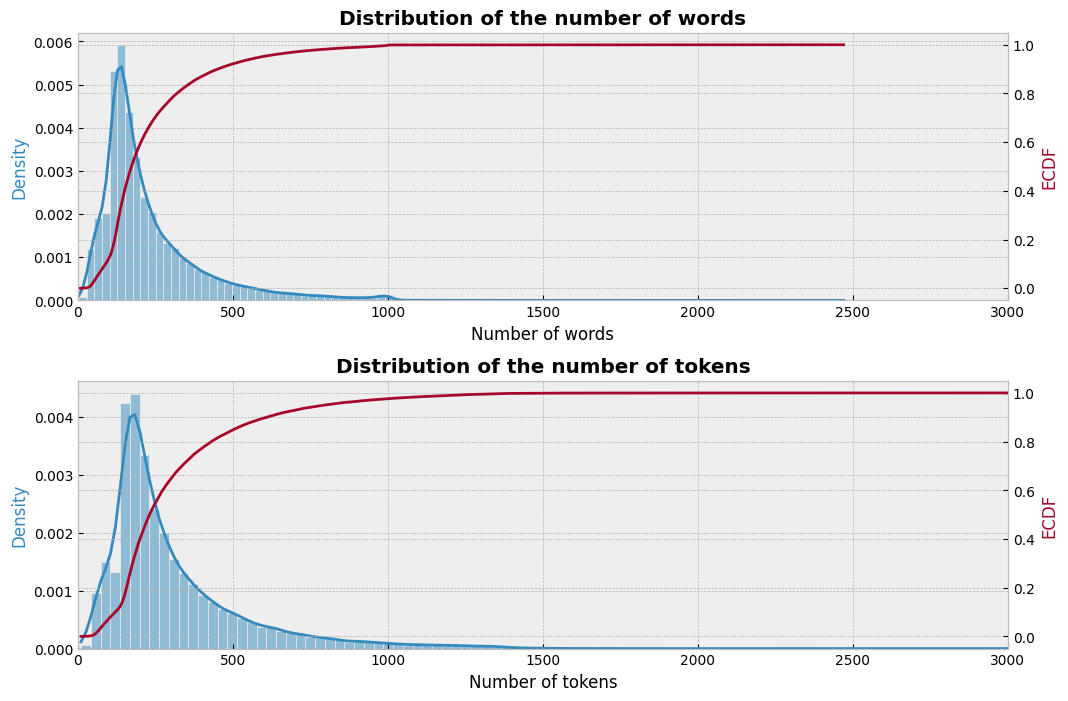

In [7]:
# Visualize distribution of the lenths and token lengths
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Number of words in a movie review (separated by spaces)
res_len = stats.ecdf(df_imdb["len_review"])

sns.histplot(df_imdb["len_review"], bins=100, kde=True, stat="density", ax=ax[0])
ax[0].set_ylabel("Density", color="C0")
ax[0].set_xlabel("Number of words")
ax[0].set_xlim(0, 3000)
ax[0].set_title("Distribution of the number of words", weight="bold")

ax0_twin = ax[0].twinx()
ax0_twin.plot(res_len.cdf.quantiles, res_len.cdf.probabilities, color="C1")
ax0_twin.set_ylabel("ECDF", color="C1")


# Number of tokens in a movie review (obtained via the DistilBERT tokenizer)
res_token_len = stats.ecdf(df_imdb["token_len_review"])

sns.histplot(df_imdb["token_len_review"], bins=100, kde=True, stat="density", ax=ax[1])
ax[1].set_ylabel("Density", color="C0")
ax[1].set_xlabel("Number of tokens")
ax[1].set_xlim(0, 3000)
ax[1].set_title("Distribution of the number of tokens", weight="bold")

ax1_twin = ax[1].twinx()
ax1_twin.plot(res_token_len.cdf.quantiles, res_token_len.cdf.probabilities, color="C1")
ax1_twin.set_ylabel("ECDF", color="C1")

plt.subplots_adjust(hspace=0.3)

## RNN and LSTM

In this section, we will delve into traditional sequential models, including RNNs (Recurrent Neural Networks) and LSTMs (Long Short-Term Memory networks).

### Dataset

First, we will construct a `Dataset`` class designed to facilitate the process of loading data in batches for downstream tasks.
This dataset will provide us with tokenized reviews, represented as IDs, along with their corresponding labels, where "0" indicates a "negative" review and "1" means a "positive" review.

A slight adjustment we'll implement involves remapping the original token IDs to consecutive ones.
This step is necessary because the vocabulary present in our dataset is more compact than that of the tokenizer's. By doing so, we ensure that our text is properly formatted for the model's input requirements.

In [8]:
class RNNDataSetIMDB(Dataset):
    """
    Dataset for both RNN model and LSTM model.
    Tokenized review in the form of ids will be used as input.
    """

    def __init__(self, df_imdb, max_seq_len=512, tokenizer=None, remap_dict=None):
        """
        - df_imdb: dataframe containing the IMDB dataset, with columns "text" and "label"
        - max_seq_len: maximum sequence length for the tokenized review. Shorter sequences will be padded, and longer sequences will be truncated.
        - tokenizer: tokenizer to use. If None, a basic BERT tokenizer will be used.
        - remap_dict: whether to remap token ids to be consecutive integers starting from 0
        """
        self.df = df_imdb
        self.max_seq_len = max_seq_len
        self.remap_dict = remap_dict

        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained(
                "distilbert/distilbert-base-uncased"
            )
        else:
            self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tokens = self.tokenizer.encode(
            row["text"],
            max_length=self.max_seq_len,
            padding="max_length",
            truncation=True,
        )

        if self.remap_dict is not None:
            tokens = [self.remap_dict[str(t)] for t in tokens]

        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "label": torch.tensor(row["label"], dtype=torch.long),
        }

In [9]:
# Get the vocabulary size
vocab_set = set({0})
for text in df_subset["text"]:
    token_ids = tokenizer_distilbert.encode(text)
    vocab_set.update(set(token_ids))


# Get the remapping dictionary (for later use --- consistency with the Embedding layer)
remap_dict = {str(old_id): new_id for new_id, old_id in enumerate(vocab_set)}

print("Vacabulary size of the data:", len(vocab_set))
print("Vacabulary size of the tokenizer:", tokenizer_distilbert.vocab_size)

Vacabulary size of the data: 22882
Vacabulary size of the tokenizer: 30522


In [10]:
temp_ds = RNNDataSetIMDB(
    df_subset, max_seq_len=512, tokenizer=tokenizer_distilbert, remap_dict=remap_dict
)
print(temp_ds[0])

{'input_ids': tensor([    1,   111, 11777,  2827, 19352,    14,  5205,  7293,   273, 14096,
         2989,    87,    84,   777,   465,   890,    93,   136,  2508,    28,
           97,    89,    84,   122,    88,   746,   107,  7922,   484,    93,
          277, 11277,   273,    14,    86,    97,    89,    84,   287,   122,
          351,    88,   358,   101,    84, 22151,   182,  2905,    85,  1154,
         2691,    14,   212,    93,   137,   742,    15,  3229,   109,   239,
           15,  4153,  3661,    15,  5824,    15,  8864,    87,    84,   466,
            9,    59,    86,   953,     9,    59,    16,    30,  5947,    17,
           32,    30,  5947,    17,    32,  1154,    89,   116,    85,    84,
          122,  3424,  2905,    88,   278,    41,  9359,   134,    84,   322,
         1974,    14,   117,    89,   232,    87,   137, 18352,    16,   109,
           84,  2905,     9,  5458,    92,  1217,    85,   777, 13116,  2424,
          140,   110,  2836,    16,   132,   111, 

### Model

Next, we will construct the sequential model according to the following architecture:

1. First, the tokenized reviews, represented as IDs, will be input into an [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). This layer converts the discrete token IDs into continuous embeddings that are trainable.
2. Subsequently, these review embeddings are passed to a sequential layer, which could be either an [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or an [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), depending on your choice.
3. The model then extracts the final hidden state from the sequence and inputs it into a [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), which outputs the logits corresponding to sentiment predictions.

A graphical representation of the model's structure will be provided for further clarification.

In [11]:
class RNN(nn.Module):
    """
    Sequantial model using either RNN or LSTM
    """

    def __init__(
        self, input_dim, embedding_dim, hidden_dim, output_dim, seq_model="rnn"
    ):
        """
        Initialize different layers of the model.
        - input_dim: input dimension of the embedding layer, i.e., the size of the vocabulary
        - embedding_dim: dimension of the token embeddings
        - hidden_dim: dimension of the hidden state of the RNN layer or LSTM layer
        - output_dim: dimension of the output layer (i.e., the number of classes in the classification task)
        - seq_model: whether to use RNN or LSTM layers in the sequential model
        """

        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Use nn.RNN for a regular RNN model or nn.LSTM for an LSTM model
        assert seq_model in [
            "rnn",
            "lstm",
        ], "seq_model should be either 'rnn' or 'lstm'"
        if seq_model == "rnn":
            self.rnn = nn.RNN(
                embedding_dim, hidden_dim, batch_first=True, nonlinearity="relu"
            )
        if seq_model == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, tokenized_text):
        "Define the forward pass of the model."
        embedded = self.embedding(tokenized_text)

        if isinstance(self.rnn, nn.RNN):
            _, hidden = self.rnn(embedded)
        if isinstance(self.rnn, nn.LSTM):
            _, (hidden, _) = self.rnn(embedded)

        hidden.squeeze_(0)
        output = self.fc(hidden)
        return output

### Training

Initially, we define the hyperparameters required for creating the model and those necessary for the training process.
You have the option to modify `seq_model` to select the type of layers used in the sequential model, choosing either `lstm` or `rnn`.

Furthermore, you may adjust other hyperparameters (including tokenizer. Yes, tokenizer also matters!) see how the evaluation result changes.
In real-world scenarios, it is good to perform hyperparameter optimization to identify the optimal settings.
For those interested in this process, some widely used optimization frameworks include [Optuna](https://optuna.org/) and [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).

In [12]:
# Specify model hyper-parameters
seq_model = "lstm"  # choose from "rnn" or "lstm"
max_seq_len = 128
vocab_size = len(vocab_set)
output_size = 2
embedding_dim = 128
hidden_dim = 256

device = "cuda:0"

# Specify training hyper-parameters
lr = 0.005
epochs = 20
batch_size = 128

Next, we instantiate datasets (split into train and validation part), dataloaders, model, loss function and optimizer.

In [13]:
# Set random seed for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Instantiate the dataset and dataloader
ds = RNNDataSetIMDB(
    df_subset,
    max_seq_len=max_seq_len,
    tokenizer=tokenizer_distilbert,
    remap_dict=remap_dict,
)
train_ratio = 0.8
ds_train, ds_val = random_split(
    ds, [int(train_ratio * len(ds)), len(ds) - int(train_ratio * len(ds))]
)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = RNN(vocab_size, embedding_dim, hidden_dim, output_size, seq_model=seq_model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


print("Training size:", len(ds_train))
print("Validation size:", len(ds_val))
print("Sequential Model:", model)

Training size: 6000
Validation size: 1500
Sequential Model: RNN(
  (embedding): Embedding(22882, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Let's visualize the network using a batch of data as input. The input shape is (128, 128), where the first 128 is the batch size and the second one is the sequence length (they don't have to be the same)

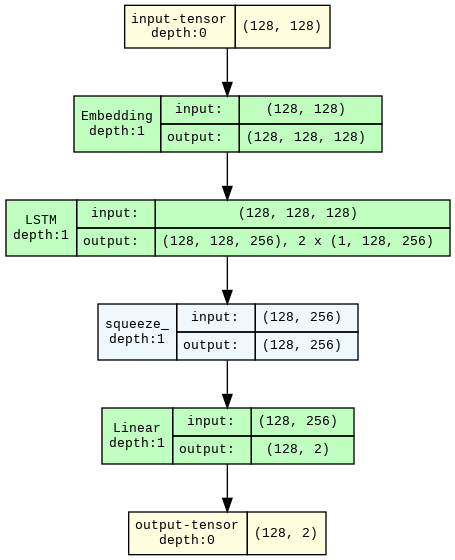

In [14]:
# Visualize the sequential model

graphviz.set_jupyter_format('png')

batch = next(iter(dl_train))
input_data = batch["input_ids"].to(device)

model_graph_1 = draw_graph(
    model, input_data=input_data, graph_name=seq_model.upper(),
    roll=True
)
model_graph_1.visual_graph

We will define some utility functions for training and evaluation based on one epoch.

In [15]:
def train_one_epoch_rnn(model, dl_train, criterion, optimizer, device, grad_clip=None):
    """
    Train the model for one epoch.
    - model: the model to train
    - dl_train: the training dataloader
    - criterion: the loss function
    - optimizer: the optimizer
    - device: the device to use (e.g., "cuda:0")
    - grad_clip: the gradient clipping value
    """

    model.train()
    running_loss = 0.0
    running_corrects = 0
    training_history = []

    for batch in tqdm(dl_train, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        ## gradient clipping to avoid exploding gradients
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        optimizer.step()
        optimizer.zero_grad()

        training_history.append(loss.item())
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dl_train.dataset)
    epoch_acc = running_corrects.double() / len(dl_train.dataset)

    return training_history, epoch_loss, epoch_acc.item()


def evaluate_rnn(model, dl, criterion, device):
    """
    Evaluate the model on the validation set.
    - model: the model to evaluate
    - dl: the validation or test dataloader
    - criterion: the loss function
    - device: the device to use (e.g., "cuda:0")
    """

    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for batch in tqdm(dl, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.item() / len(dl.dataset)

    return epoch_acc

In [16]:
model = model.to(device)

# Clip the gradients for RNN model
grad_clip = 1 if seq_model == "rnn" else None

# Checkpoint path
best_acc = 0
ckpt_path = os.path.join(ckpt_dir, f"best_model_{seq_model}.pt")

training_history = {
    "batch_loss_train": [],
    "epoch_loss_train": [],
    "epoch_acc_train": [],
    "epoch_acc_val": [],
}

print("---" * 10 + " Start Training " + "---" * 10)
for epoch in range(epochs):
    # Training on training set and evaluate on validation set
    temp_history, train_loss, train_acc = train_one_epoch_rnn(
        model, dl_train, criterion, optimizer, device, grad_clip=grad_clip
    )
    val_acc = evaluate_rnn(model, dl_val, criterion, device)

    # Early stopping and save the best checkpoint based on validation metric
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), ckpt_path)

    # Logging relevant metrics
    training_history["batch_loss_train"].extend(temp_history)
    training_history["epoch_loss_train"].append(train_loss)
    training_history["epoch_acc_train"].append(train_acc)
    training_history["epoch_acc_val"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}"
    )

------------------------------ Start Training ------------------------------


Epoch 1/20 | Train loss: 0.6977 | Train acc: 0.5022 | Val acc: 0.5387


Epoch 2/20 | Train loss: 0.6813 | Train acc: 0.5622 | Val acc: 0.5400


Epoch 3/20 | Train loss: 0.5771 | Train acc: 0.6977 | Val acc: 0.5953


Epoch 4/20 | Train loss: 0.3392 | Train acc: 0.8487 | Val acc: 0.5960


Epoch 5/20 | Train loss: 0.1596 | Train acc: 0.9385 | Val acc: 0.5993


Epoch 6/20 | Train loss: 0.0676 | Train acc: 0.9772 | Val acc: 0.6220


Epoch 7/20 | Train loss: 0.0304 | Train acc: 0.9905 | Val acc: 0.6387


Epoch 8/20 | Train loss: 0.0215 | Train acc: 0.9940 | Val acc: 0.6020


Epoch 9/20 | Train loss: 0.0139 | Train acc: 0.9953 | Val acc: 0.6007


Epoch 10/20 | Train loss: 0.0153 | Train acc: 0.9953 | Val acc: 0.6113


Epoch 11/20 | Train loss: 0.0128 | Train acc: 0.9963 | Val acc: 0.6073


Epoch 12/20 | Train loss: 0.0092 | Train acc: 0.9980 | Val acc: 0.5967


Epoch 13/20 | Train loss: 0.0202 | Train acc: 0.9945 | Val acc: 0.5927


Epoch 14/20 | Train loss: 0.0166 | Train acc: 0.9947 | Val acc: 0.6093


Epoch 15/20 | Train loss: 0.0126 | Train acc: 0.9953 | Val acc: 0.5873


Epoch 16/20 | Train loss: 0.0098 | Train acc: 0.9973 | Val acc: 0.6060


Epoch 17/20 | Train loss: 0.0048 | Train acc: 0.9985 | Val acc: 0.6013


Epoch 18/20 | Train loss: 0.0008 | Train acc: 1.0000 | Val acc: 0.6147


Epoch 19/20 | Train loss: 0.0003 | Train acc: 1.0000 | Val acc: 0.6140


Epoch 20/20 | Train loss: 0.0002 | Train acc: 1.0000 | Val acc: 0.6133


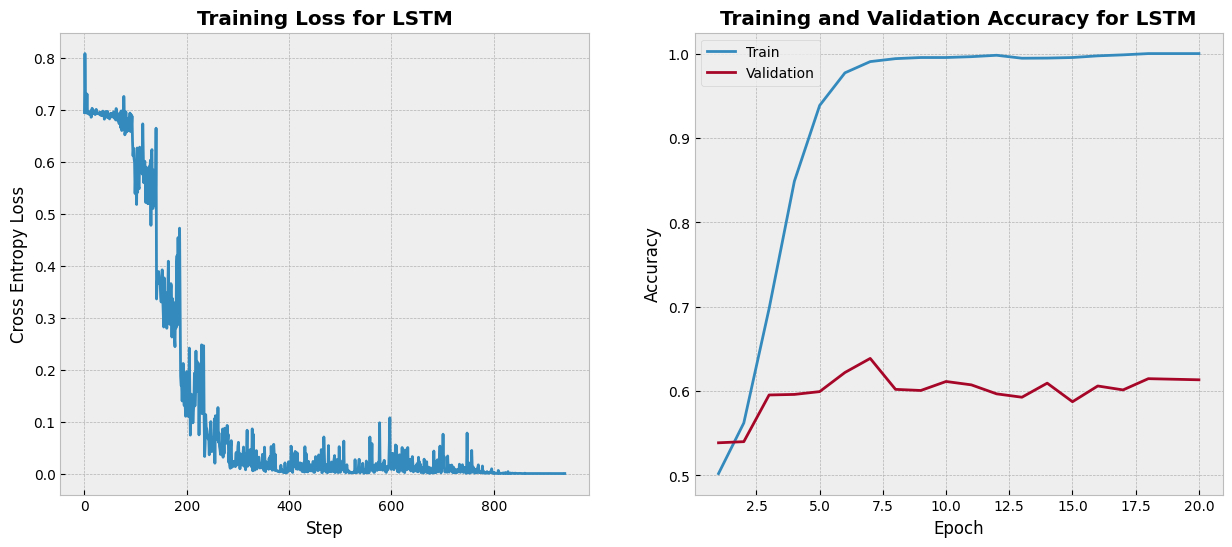

In [17]:
# Visualize the training loss
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(training_history["batch_loss_train"])
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].set_title(f"Training Loss for {seq_model.upper()}", weight="bold")


ax[1].plot(
    np.arange(1, epochs + 1),
    training_history["epoch_acc_train"],
    label="Train",
)
ax[1].plot(
    np.arange(1, epochs + 1),
    training_history["epoch_acc_val"],
    label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(
    f"Training and Validation Accuracy for {seq_model.upper()}", weight="bold"
)
ax[1].legend()

It's evident that the sequential model is overfitting to the training data and having really bad generalization on the validation set.
To achieve the best possible outcome, it's advisable to utilize all available data (remember, we used only a small subset of the reviews for illustrative purposes), and perform hyper-parameter tuning on tokenizers, network architectures, training configurations and etc.

### Load Trained Model

In [18]:
# Instantiate the model with same set of hyper-parameters
model = RNN(vocab_size, embedding_dim, hidden_dim, output_size, seq_model=seq_model)

# Load saved checkpoint
print("Loading the best checkpoint from path:", ckpt_path)
model.load_state_dict(torch.load(ckpt_path))

print(model)

Loading the best checkpoint from path: ./tutorial_ckpt/best_model_lstm.pt
RNN(
  (embedding): Embedding(22882, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


## Transformer

In this part, we will fine-tune a pre-trained BERT-like transformer model, specifically [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert), to perform sentiment analysis.
We will import this pre-trained model directly from the HuggingFace model repository for the purpose of fine-tuning.

### Dataset

In [19]:
# Prepare IMDB dataset
class BERTDatasetIMDB(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df.iloc[idx]["text"]
        target = self.df.iloc[idx]["label"]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].flatten()
        attention_mask = encoding["attention_mask"].flatten()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "targets": torch.tensor(target, dtype=torch.long),
        }

### Model and Training

In [20]:
# Specify hyper-parameters

max_len = 512  # maximum sequence length

epochs = 5
batch_size = 16
lr = 1e-5


device = "cuda:0"

In [21]:
# Set random seed for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# Instantiate the dataset and dataloader
ds = BERTDatasetIMDB(df=df_subset, tokenizer=tokenizer_distilbert, max_len=max_len)
train_ratio = 0.8
ds_train, ds_val = random_split(
    ds, [int(train_ratio * len(ds)), len(ds) - int(train_ratio * len(ds))]
)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)


# Instantiate the model and optimizer
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, output_attentions=True
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


print("Training size:", len(ds_train))
print("Validation size:", len(ds_val))
print("Model:", model)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training size: 6000
Validation size: 1500
Model: DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
     

The high-level structure of the imported model is straightforward:
it consists of a DistilBERT model tasked with generating sequence embeddings through transformer encoders, followed by a classification head attached at the model's output.
This approach mirrors what we would have implemented had this comprehensive classification model not been readily accessible in the model hub.

Let's visualize this DistilBERT classifier for better illustration.

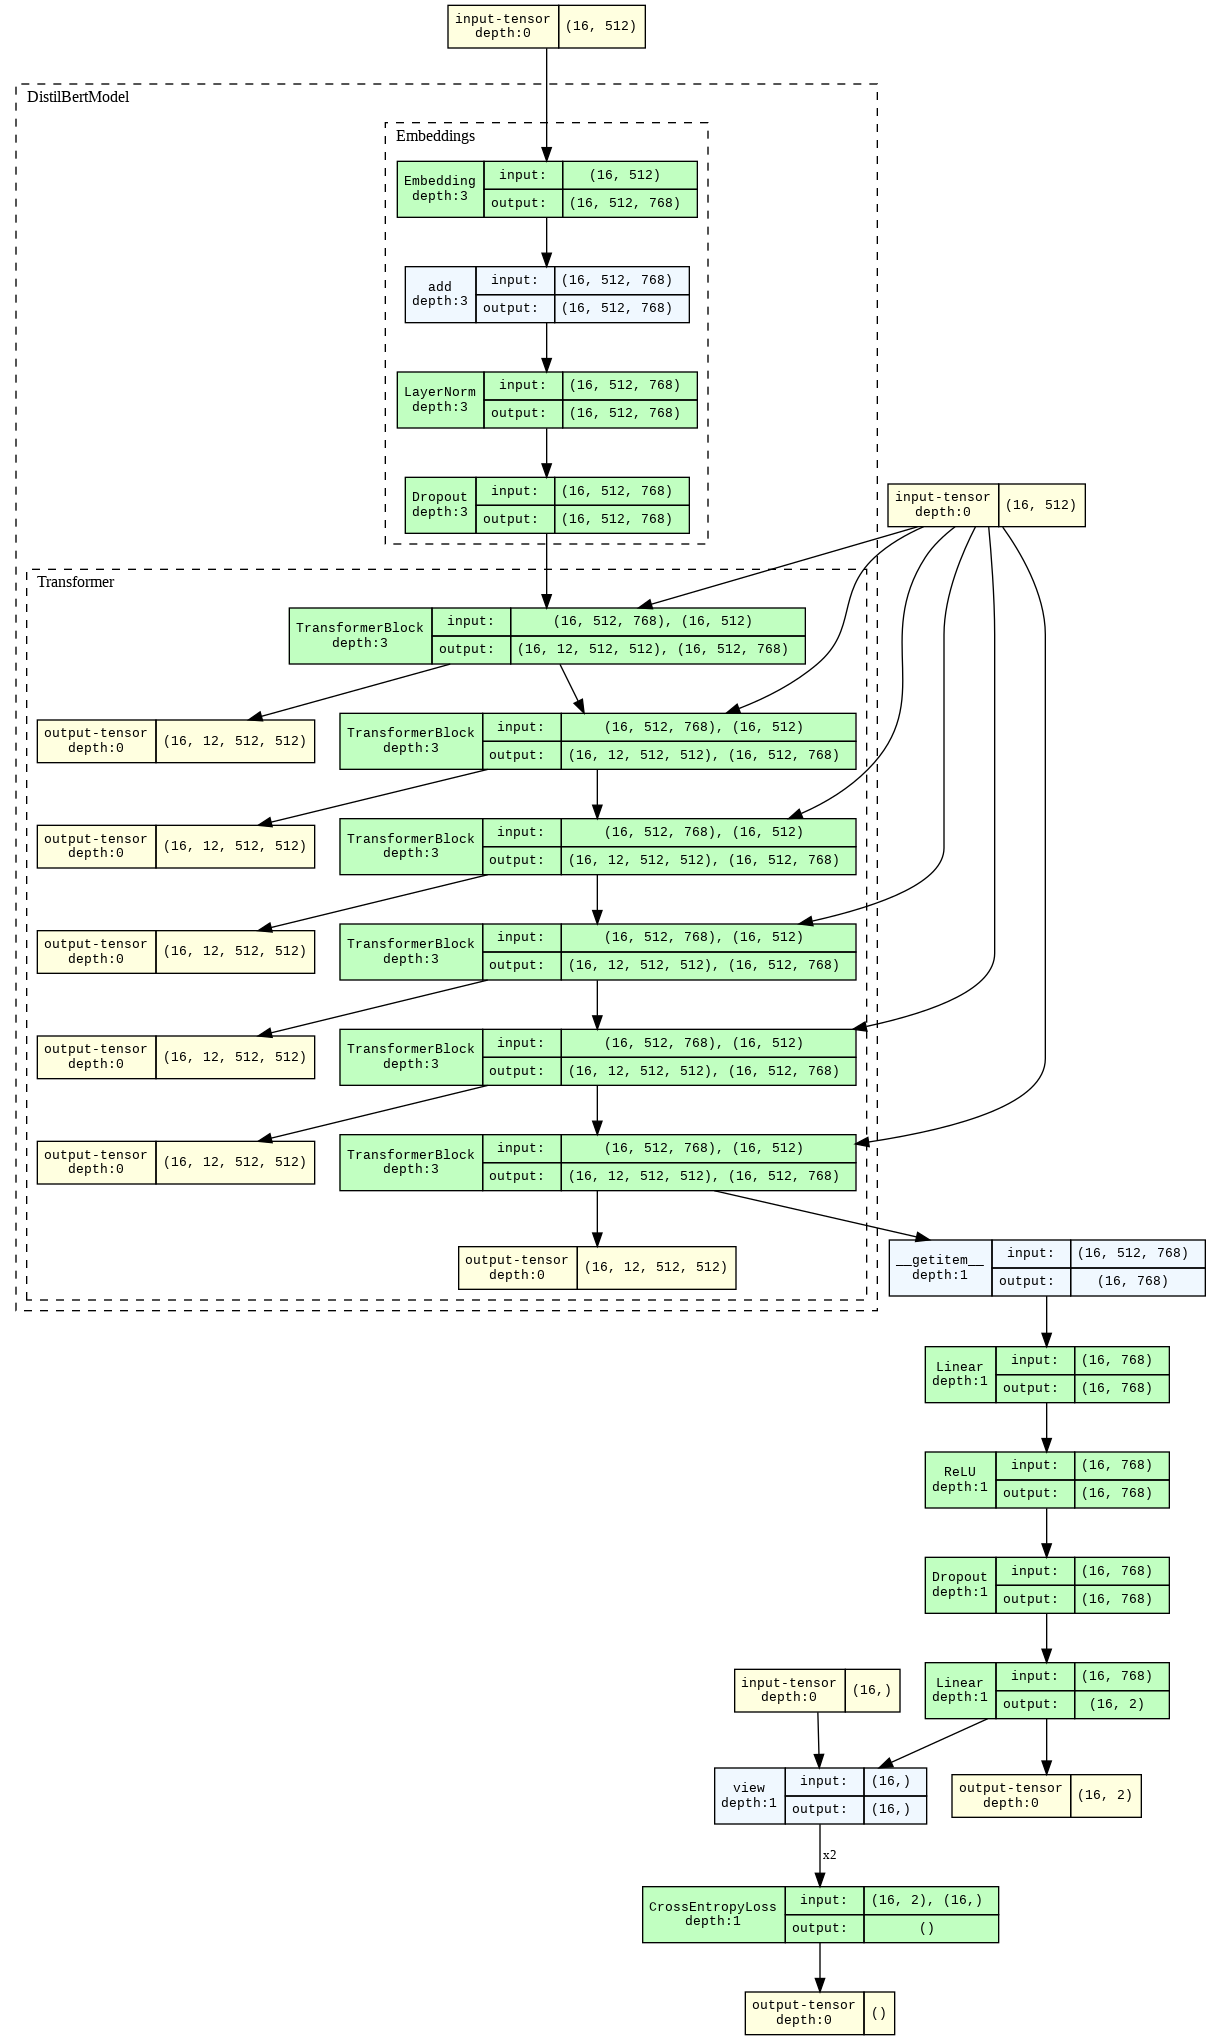

In [22]:
# Visualize the transformer classifier

graphviz.set_jupyter_format('png')

batch = next(iter(dl_train))
input_data = {
    "input_ids": batch["input_ids"].to(device),
    "attention_mask": batch["attention_mask"].to(device),
    "labels": batch["targets"].to(device),
}

model_graph_2 = draw_graph(
    model, input_data=input_data, graph_name="transformer", expand_nested=True,
    roll=True,
)
model_graph_2.visual_graph

We will define similar utility functions for training and evaluation.

In [23]:
def train_one_epoch_transformer(model, dl_train, optimizer, device):
    """
    Train the model for one epoch.
    - model: the model to train
    - dl_train: the training dataloader
    - optimizer: the optimizer
    - device: the device to use (e.g., "cuda:0")
    """

    model.train()
    running_loss = 0.0
    running_corrects = 0
    training_history = []

    for batch in tqdm(dl_train, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["targets"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_history.append(loss.item())
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += torch.sum(torch.argmax(logits, 1) == labels)

    epoch_loss = running_loss / len(dl_train.dataset)
    epoch_acc = running_corrects.double() / len(dl_train.dataset)

    return training_history, epoch_loss, epoch_acc.item()


def evaluate_transformer(model, dl, device):
    """
    Evaluate the model on the validation set.
    - model: the model to evaluate
    - dl: the validation or test dataloader
    - device: the device to use (e.g., "cuda:0")
    """

    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for batch in tqdm(dl, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["targets"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            running_corrects += torch.sum(torch.argmax(logits, 1) == labels)

    epoch_acc = running_corrects.item() / len(dl.dataset)

    return epoch_acc

We start fine-tuning here.

In [24]:
model = model.to(device)

# Checkpoint path
best_acc = 0
ckpt_path = os.path.join(ckpt_dir, f"transformer_distilbert.pt")


# Let's check the model performance before training
print("---" * 10 + " Accuracy of the Pre-Trained Model " + "---" * 10)

train_acc_pretrained = evaluate_transformer(model, dl_train, device)
print(f"Training accuracy of the pre-trained model: {train_acc_pretrained:.4f}")

val_acc_pretrained = evaluate_transformer(model, dl_val, device)
print(f"Validation accuracy of the pre-trained model: {val_acc:.4f}")


training_history = {
    "batch_loss_train": [],
    "epoch_loss_train": [],
    "epoch_acc_train": [train_acc_pretrained],
    "epoch_acc_val": [val_acc_pretrained],
}


# Start training
print("---" * 10 + " Start Training " + "---" * 10)
for epoch in range(epochs):
    # Training on training set and evaluate on validation set
    temp_history, train_loss, train_acc = train_one_epoch_transformer(
        model, dl_train, optimizer, device
    )
    val_acc = evaluate_transformer(model, dl_val, device)

    # Early stopping and save the best checkpoint based on validation metric
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), ckpt_path)

    # Logging relevant metrics
    training_history["batch_loss_train"].extend(temp_history)
    training_history["epoch_loss_train"].append(train_loss)
    training_history["epoch_acc_train"].append(train_acc)
    training_history["epoch_acc_val"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}"
    )

------------------------------ Accuracy of the Pre-Trained Model ------------------------------


Training accuracy of the pre-trained model: 0.4895


Validation accuracy of the pre-trained model: 0.6133
------------------------------ Start Training ------------------------------


Epoch 1/5 | Train loss: 0.3562 | Train acc: 0.8402 | Val acc: 0.9027


Epoch 2/5 | Train loss: 0.1822 | Train acc: 0.9303 | Val acc: 0.9207


Epoch 3/5 | Train loss: 0.1103 | Train acc: 0.9647 | Val acc: 0.9173


Epoch 4/5 | Train loss: 0.0623 | Train acc: 0.9812 | Val acc: 0.9073


Epoch 5/5 | Train loss: 0.0436 | Train acc: 0.9868 | Val acc: 0.9100


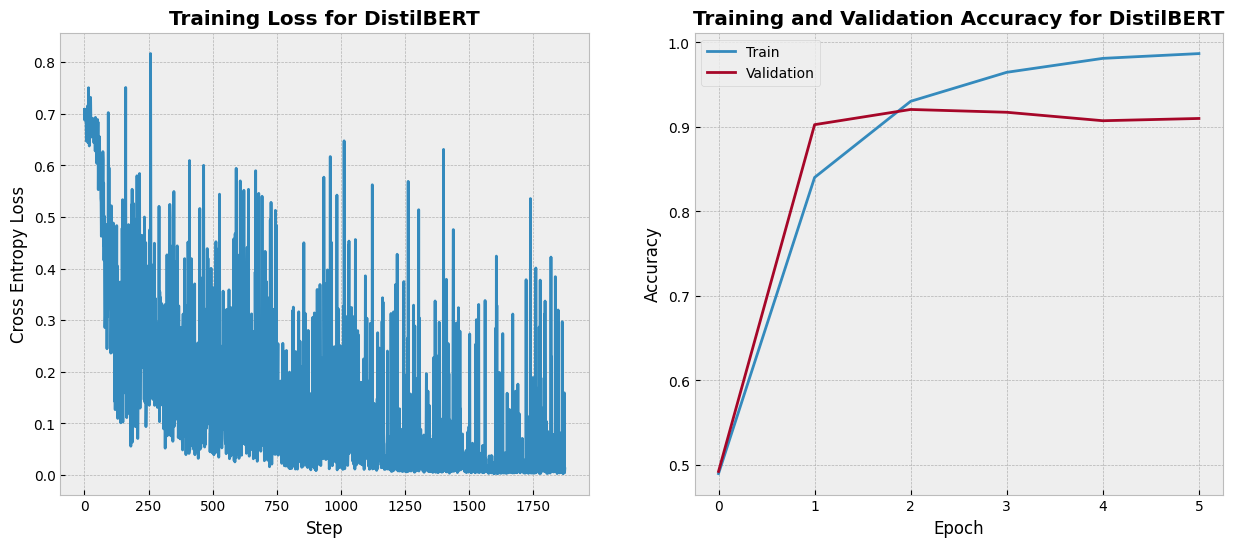

In [25]:
# Visualize the training loss
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(training_history["batch_loss_train"])
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].set_title("Training Loss for DistilBERT", weight="bold")


ax[1].plot(
    np.arange(epochs + 1),
    training_history["epoch_acc_train"],
    label="Train",
)
ax[1].plot(
    np.arange(epochs + 1),
    training_history["epoch_acc_val"],
    label="Validation",
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(
    "Training and Validation Accuracy for DistilBERT", weight="bold"
)
ax[1].legend()

We can see that even though the pre-trained model itself already has fair enough validation accuracy to start with, and the fine-tuning of only 5 epochs makes it even better.


### Load Trained Model

In [26]:
# Instantiate the model with same set of hyper-parameters
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, output_attentions=True
)

# Load saved checkpoint
print("Loading the best checkpoint from path:", ckpt_path)
model.load_state_dict(torch.load(ckpt_path))

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading the best checkpoint from path: ./tutorial_ckpt/transformer_distilbert.pt
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=T